<a href="https://colab.research.google.com/github/aafaf-arharas/ML_TPs/blob/main/06_Transfer_Learning_Keras_etud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fine Tuning



Objectif : utiliser un réseau pré entraîné et une technique de Fine Tuning pour apprendre une classification de données personnelles. Les données étant en nombre insuffisant, une technique d'augmentation de données sera utilisée.

## Imports

In [11]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [13]:
# Paramètres 
image_shape = (224, 224, 3)
image_size = image_shape[:2]

batch_size = 32
num_classes = 5


## Données 

In [18]:
def Data():
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos',cache_dir = '/Documents',untar=True)
    data_dir = pathlib.Path(data_dir)

    print("Nombre d'images :", len(list(data_dir.glob('*/*.jpg'))))

    classes = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    print("Classes : ",classes)

    #train_data, test_data = train_test_split(data_dir, test_size=0.25)


    # Augmentation de données : 75% entraînement, 25% test
    image_gen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.25) # TODO : utiliser ImageDataGenerator


    

    # Augmentation de la base d'entraînement
    train_data_gen = image_gen.flow_from_directory(data_dir,  batch_size=32, class_mode='')#TODO 
    # Augmentation de la base de test/validation
    test_data_gen = image_gen.flow_from_directory(data_dir,  batch_size=32, class_mode=) #TODO
    return train_data_gen, test_data_gen, classes


In [19]:
def TransferModel(input_shape,stop_freeze):

    pretrained_model = MobileNetV2(input_shape= input_shape, weights='imagenet' ) #TODO : charger MobileNetV2

    # On ôte la dernière couche de classification
    #TODO
    pretrained_model.layers.pop()

    # On fige tous les poids sauf ceux des stop_freeze dernières couches
    #TODO
    
    for i in range(len(pretrained_model.layers) - stop_freeze) :
      layer = pretrained_model.get_layer(index=i)
      layer.trainable = False



    # On rajoute en bout de réseau notre couche de classification pour le problème 
    #TODO
    pretrained_model.add(Dense(5, activation="relu"))
    model = pretrained_model() 
    return model
 

## Réseau 

In [20]:
num_epochs = 10
stop_freeze = 4

# Chargement des données augmentées
x_train, x_test, classes = Data()

# Modèle
model = TransferModel(input_shape=image_shape,stop_freeze = stop_freeze)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("sauve"):
    os.mkdir("sauve")
    
checkpoint = ModelCheckpoint("sauve/MobileNetV2_flowers-loss-{val_loss:.2f}-acc-{accuracy:.2f}.h5",
                                save_best_only=True,verbose=1)

train_steps_epoch = np.ceil(x_train.samples / batch_size)
val_steps_epoch = np.ceil(x_test.samples / batch_size)

# Entraînement
model.fit(x_train, steps_per_epoch=train_steps_epoch,
                        validation_data=x_test, validation_steps=val_steps_epoch,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Nombre d'images : 3670
Classes :  ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Found 3670 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.
14548992/14536120 [==============================] - 1s 0us/step


AttributeError: ignored

In [ ]:
# On construit le meilleur modèle appris
model = TransferModel(input_shape=image_shape,stop_freeze=2 )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.load_weights("sauve/MobileNetV2_flowers-loss-2.12-acc-0.93.h5")

# Evaluation du modèle
evaluation = model.evaluate(x_test, steps=val_steps_epoch, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

29/29 [==============================] - 17s 572ms/step - loss: 2.1137 - accuracy: 0.8459
Perte = 2.114, Précision = 0.846


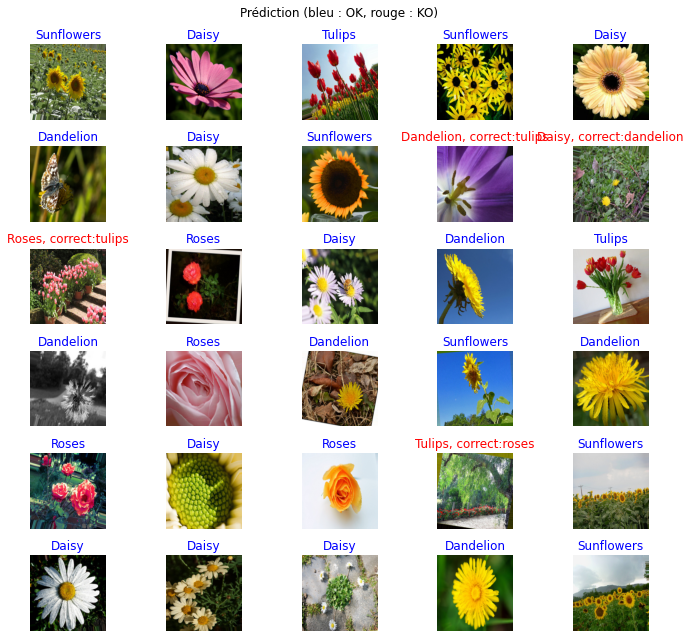

In [ ]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)